In [1]:
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [2]:
import os
from datasets import load_dataset
import pandas as pd
import tensorflow as tf
import pandas as pd
import numpy as np
import transformers
from transformers import LongformerTokenizer
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam
print(tf.__version__)
print(transformers.__version__)

2.18.0
4.52.4


In [3]:
dataset = load_dataset("mohammadjavadpirhadi/fake-news-detection-dataset-english", download_mode='force_redownload')
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/786 [00:00<?, ?B/s]

(…)-00000-of-00001-31aecafc15fe32e0.parquet:   0%|          | 0.00/57.0M [00:00<?, ?B/s]

(…)-00000-of-00001-1d49200ad03190fd.parquet:   0%|          | 0.00/14.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/35918 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8980 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'subject', 'date', 'label'],
        num_rows: 35918
    })
    test: Dataset({
        features: ['title', 'text', 'subject', 'date', 'label'],
        num_rows: 8980
    })
})

In [4]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Num GPUs Available: 1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2619520565239634282
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40419328000
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15570378326229943019
physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
xla_global_id: 416903419
]


In [5]:
train_df = pd.DataFrame(dataset['train'][:])
test_df = pd.DataFrame(dataset['test'][:])

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35918 entries, 0 to 35917
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    35918 non-null  object
 1   text     35918 non-null  object
 2   subject  35918 non-null  object
 3   date     35918 non-null  object
 4   label    35918 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.4+ MB


In [7]:
train_df['label'].value_counts()/len(train_df) * 100

,count
label,
1,52.352581
0,47.647419


In [8]:
train_df.head()

,title,text,subject,date,label
0,"Saudi Arabia says foils Islamic State bomb, fo...",DUBAI (Reuters) - Saudi Arabia said on Tuesday...,worldnews,"September 11, 2017",0
1,GOP Just Demanded Hillary Clinton Give Them A...,"On Wednesday, the GOP in an effort to deflec...",News,"July 5, 2017",1
2,AUDIT REVEALS: 150 AFGHAN TROOPS Have Gone AWO...,The new report on the number of missing Afghan...,politics,"Oct 20, 2017",1
3,Watch Elizabeth Warren DESTROY Donald Trump i...,Senator Elizabeth Warren (D-MA) lit into Repub...,News,"March 21, 2016",1
4,Mohammed Dahlan speaks about Palestinian unity...,"GAZA (Reuters) - Mohammad Dahlan, who played a...",worldnews,"October 4, 2017",0


<Axes: xlabel='subject'>

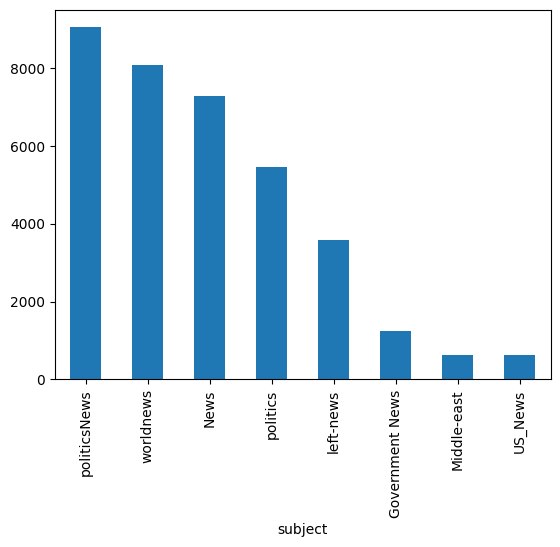

In [9]:
num_subjects = train_df['subject'].value_counts()
num_subjects.plot(kind='bar')

<Axes: xlabel='label'>

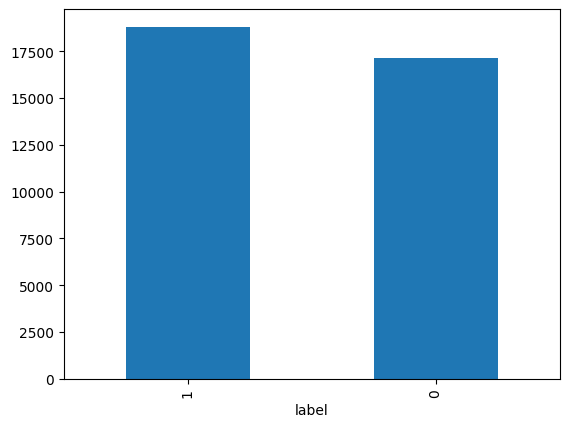

In [10]:
num_clases = train_df['label'].value_counts()
num_clases.plot(kind='bar')

In [11]:
train_df.isnull().sum()

,0
title,0
text,0
subject,0
date,0
label,0


In [12]:
train_df['subject'] = train_df['subject'].astype(str)
train_df['title'] = train_df['title'].astype(str)
train_df['text'] = train_df['text'].astype(str)
test_df['subject'] = test_df['subject'].astype(str)
test_df['title'] = test_df['title'].astype(str)
test_df['text'] = test_df['text'].astype(str)

In [13]:
train_df['full_text'] = " [TITLE] " + train_df['title'] + " [TEXT] " + train_df['text']
test_df['full_text'] = " [TITLE] " + test_df['title'] +" [TEXT] " + test_df['text']
train_df.drop(['title', 'text', 'subject', 'date'], axis=1, inplace=True)
test_df.drop(['title', 'text', 'subject', 'date'], axis=1, inplace=True)

In [14]:
max_len = 0
for i in range(len(train_df)):
  if len(train_df['full_text'][i]) > max_len:
    max_len = len(train_df['full_text'][i])
    id = i
print(max_len)
print(id)

51909
5242


In [15]:
train_df['full_text'][5242]

' [TITLE] MEDIA TRIPWIRE? Ping Pong Pizza Conspiracy Propels Internet Censorship Amid ‘Fake News’ Witch-Hunt [TEXT]  Funny how secrets travel. I d start to believe, if I were to bleed.    Lyrics written by David Bowie from the album OutsideShawn Helton 21st Century Wire In the days before the US presidential election in November 2016, Wikileaks revealed a new string of emails connected to Hillary Clinton s 2016 campaign chairman, John Podesta. Online interpretations of the leaked Podesta email exchanges subsequently led to a digital firestorm on social media, producing an intense conspiratorial  open source investigation  still in search of its smoking gun. However, the phenomenon now known by its hashtag #Pizzagate has since set a number of tertiary events into motion. Is there a real story hidden amongst the debris of this online explosion?Is it possible that  open source investigators  were being led into a virtual cul-de-sac and thus missing the real story?More importantly, could p

In [16]:
min_len = max_len
for i in range(len(train_df)):
  if len(train_df['full_text'][i]) < min_len:
    min_len = len(train_df['full_text'][i])
    id = i
print(min_len)
print(id)

47
26726


In [17]:
train_df['full_text'][26726]

' [TITLE] LIVE FEED: INAUGURATION 2017! [TEXT]  '

<Axes: >

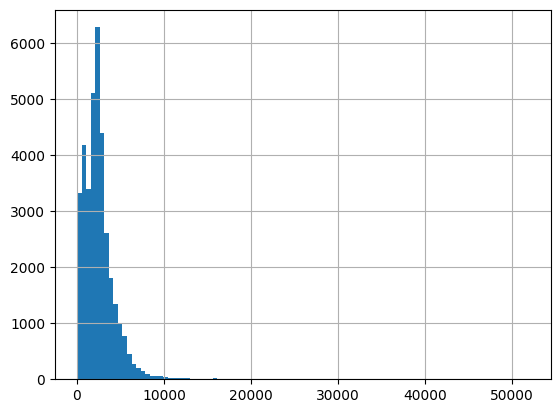

In [18]:
len_char = train_df['full_text'].apply(len)
len_char.hist(bins=100)

In [19]:
len_char.describe()

,full_text
count,35918.000000
mean,2563.422657
std,2161.731577
min,47.000000
25%,1338.250000
50%,2283.000000
75%,3194.750000
max,51909.000000


<Axes: >

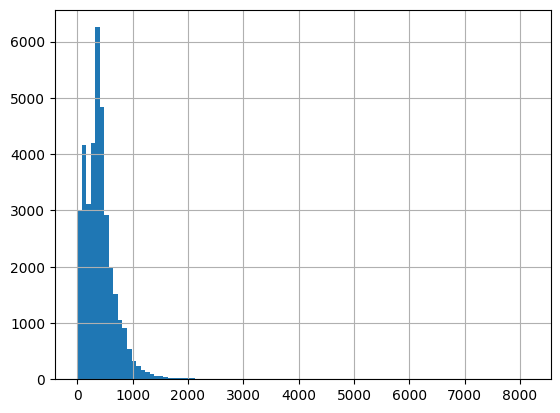

In [20]:
len_words = train_df['full_text'].apply(lambda x: len(x.split()))
len_words.hist(bins=100)

In [21]:
len_words.describe()

,full_text
count,35918.000000
mean,419.227769
std,349.390372
min,4.000000
25%,218.000000
50%,376.000000
75%,526.000000
max,8150.000000


In [22]:
num_words_more_than_75 = len_words[len_words > 800].count()
print(f'Porcentaje de registros con más de 800 palabras: {num_words_more_than_75 / len(train_df) * 100}% de {len(train_df)} registros')
num_words_less_than_25 = len_words[len_words < 70].count()
print(f'Porcentaje de registros con menos de 70 palabras: {num_words_less_than_25 / len(train_df) * 100}% de {len(train_df)} registros')

Porcentaje de registros con más de 800 palabras: 8.550030625313214% de 35918 registros
Porcentaje de registros con menos de 70 palabras: 5.532045214098781% de 35918 registros


In [23]:
train_df['full_text'].astype(str)
test_df['full_text'].astype(str)
train_df['label'].astype(int)
test_df['label'].astype(int)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35918 entries, 0 to 35917
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      35918 non-null  int64 
 1   full_text  35918 non-null  object
dtypes: int64(1), object(1)
memory usage: 561.3+ KB


In [24]:
train_texts = train_df['full_text'].tolist()
train_labels = train_df['label'].tolist()
test_texts = test_df['full_text'].tolist()
test_labels = test_df['label'].tolist()

# Model 1

In [ ]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

In [ ]:
import torch

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
test_dataset = NewsDataset(test_encodings, test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8)


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

from torch.optim import Adam
from tqdm import tqdm

optimizer = Adam(model.parameters(), lr=5e-5)

model.train()
for epoch in range(3):
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 2: 100%|██████████| 4490/4490 [06:16<00:00, 11.92it/s, loss=0.000535]


In [ ]:
print(torch.__version__)

2.6.0+cu124


In [ ]:
from sklearn.metrics import classification_report

model.eval()
preds = []
true = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds += torch.argmax(logits, dim=1).cpu().tolist()
        true += batch['labels'].cpu().tolist()

print(classification_report(true, preds))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4303
           1       1.00      1.00      1.00      4677

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [ ]:
import os
import shutil

save_dir = "distilbert_model"

model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print("Contenido de la carpeta:", os.listdir(save_dir))

shutil.make_archive("distilbert_model", "zip", save_dir)

from google.colab import files
files.download("distilbert_model.zip")

Contenido de la carpeta: ['model.safetensors', 'config.json', 'special_tokens_map.json', 'vocab.txt', 'tokenizer.json', 'tokenizer_config.json']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Model 2

In [ ]:
from transformers import AutoTokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings  = tokenizer(test_texts,  truncation=True, padding=True, max_length=512)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
test_dataset  = NewsDataset(test_encodings,  test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=8)


from transformers import AutoModelForSequenceClassification
from torch.optim import Adam
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
optimizer = Adam(model.parameters(), lr=5e-5)


model.train()
for epoch in range(2):
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 4490/4490 [12:15<00:00,  6.11it/s, loss=0.705]


In [ ]:
model.eval()
preds, true = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        logits = model(**batch).logits
        preds += torch.argmax(logits, dim=1).cpu().tolist()
        true  += batch["labels"].cpu().tolist()

print(classification_report(true, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4303
           1       0.52      1.00      0.68      4677

    accuracy                           0.52      8980
   macro avg       0.26      0.50      0.34      8980
weighted avg       0.27      0.52      0.36      8980



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import os, shutil
save_dir = "bert_model"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print("Archivos guardados:", os.listdir(save_dir))

shutil.make_archive("bert_model", "zip", save_dir)

from google.colab import files
files.download("bert_model.zip")

Archivos guardados: ['model.safetensors', 'config.json', 'special_tokens_map.json', 'vocab.txt', 'tokenizer.json', 'tokenizer_config.json']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Model 3

In [26]:
from transformers import AutoTokenizer
model_name = "albert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings  = tokenizer(test_texts,  truncation=True, padding=True, max_length=512)

import torch

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
test_dataset  = NewsDataset(test_encodings,  test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=8)

from transformers import AutoModelForSequenceClassification
from torch.optim import Adam
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
optimizer = Adam(model.parameters(), lr=5e-5)

model.train()
for epoch in range(2):
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())




Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 4490/4490 [12:58<00:00,  5.77it/s, loss=0.00284]


In [27]:
from sklearn.metrics import classification_report

model.eval()
preds, true = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        logits = model(**batch).logits
        preds += torch.argmax(logits, dim=1).cpu().tolist()
        true  += batch["labels"].cpu().tolist()

print(classification_report(true, preds))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4303
           1       0.99      1.00      1.00      4677

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [28]:
import os, shutil

save_dir = "albert_model"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print("Archivos guardados:", os.listdir(save_dir))

shutil.make_archive("albert_model", "zip", save_dir)

from google.colab import files
files.download("albert_model.zip")


Archivos guardados: ['model.safetensors', 'spiece.model', 'config.json', 'special_tokens_map.json', 'tokenizer.json', 'tokenizer_config.json']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
import json
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
preds = []
true = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds += torch.argmax(logits, dim=1).cpu().tolist()
        true += batch['labels'].cpu().tolist()

report_dict = classification_report(true, preds, output_dict=True)
with open("metrics_report.json", "w") as f:
    json.dump(report_dict, f, indent=4)

cm = confusion_matrix(true, preds)
np.save("confusion_matrix.npy", cm)


In [38]:
print(confusion_matrix(true, preds))

[[4269   34]
 [   6 4671]]
